In [299]:
from dataclasses import dataclass
import numpy as np 
from typing import Iterable, Optional, Mapping

Replicate = int
Peptide = int
Pool = int
SwapCandidateList = Iterable[tuple[Replicate, Pool, Peptide]]
ReplicateToNeighborDict = Mapping[Replicate, Mapping[Peptide, set[Peptide]]]
PeptidePairList = Iterable[tuple[Peptide, Peptide]]

@dataclass
class Spec:
    num_peptides : int
    max_peptides_per_pool : int
    num_replicates : int
    invalid_neighbors : PeptidePairList
    preferred_neighbors : PeptidePairList

@dataclass
class Solution(Spec):
    assignments : Mapping[Replicate, Mapping[Pool, Iterable[Peptide]]]
    
    def move_peptide(self, replicate_idx : Replicate, old_pool_idx : Pool, peptide : Peptide, new_pool_idx : Pool):
        """
        Move a peptide from its current pool to a new pool
        """
        pool_to_peptides = self.assignments[replicate_idx]
        old_pool = pool_to_peptides[old_pool_idx]
        new_pool = pool_to_peptides[new_pool_idx]
        assert len(new_pool) < self.max_peptides_per_pool
        pool_to_peptides[new_pool_idx] = np.array(list(new_pool) + [peptide])
        
        pool_to_peptides[old_pool_idx] = np.array([p for p in old_pool if p != peptide])
    
    def swap_peptides(
            self, replicate_idx : Replicate, 
            pool_idx_a : Pool, 
            peptide_a : Peptide, 
            pool_idx_b : Pool, 
            peptide_b : Peptide):
        """
        Move peptide A from its current pool to the pool of peptide B (and vice versa)
        """
        pool_to_peptides = self.assignments[replicate_idx]
        pool_a = pool_to_peptides[pool_idx_a]
        pool_b = pool_to_peptides[pool_idx_b]
        pool_to_peptides[pool_idx_a] = np.array([i for i in pool_a if i != peptide_a] + [peptide_b])
        pool_to_peptides[pool_idx_b] = np.array([i for i in pool_b if i != peptide_b] + [peptide_a])

        
    def remove_empty_pools(self):
        """
        Delete any empty pools and renumber the pools to be contiguous
        """
        for (replicate_idx, pool_to_peptides) in self.assignments.items():
            to_delete = [pool_idx for (pool_idx, pool) in pool_to_peptides.items() if len(pool) == 0]
            if len(to_delete) > 0:
                for pool_idx in to_delete:
                    del pool_to_peptides[pool_idx]
                index_mapping = {
                    old_idx: new_idx 
                    for (new_idx, old_idx) 
                    in enumerate(sorted(pool_to_peptides.keys()))
                }
                self.assignments[replicate_idx] = {
                    index_mapping[pool_idx]: pool
                    for (pool_idx, pool) in pool_to_peptides.items()
                }
        
    

def random_init(
        num_peptides : int = 100, 
        peptides_per_pool : int = 5,
        num_replicates : int = 3,
        num_pools : Optional[int] = None,
        invalid_neighbors : PeptidePairList = [],
        preferred_neighbors : PeptidePairList = []) -> Solution:
    if num_pools is None:
        num_pools = int(np.ceil(num_peptides / peptides_per_pool)) 
    
    preferred_neighbor_dict = defaultdict(set)
    for (p1, p2) in preferred_neighbors:
        preferred_neighbor_dict[p1].add(p2)
        preferred_neighbor_dict[p2].add(p1)
        
    replicate_to_pool_to_peptides = {}
    for i in range(num_replicates):
        peptide_array = np.arange(num_peptides)
        np.random.shuffle(peptide_array)
        pool_assignments = {}
        replicate_to_pool_to_peptides[i] = pool_assignments
        
        for j in range(num_pools):
            start_idx = peptides_per_pool * j
            end_idx = peptides_per_pool * (j + 1)
            pool_assignments[j] = peptide_array[start_idx:end_idx]
            
    return Solution(
        num_peptides=num_peptides,
        max_peptides_per_pool=peptides_per_pool,
        num_replicates=num_replicates,
        invalid_neighbors=invalid_neighbors,
        preferred_neighbors=preferred_neighbors,
        assignments=replicate_to_pool_to_peptides)



            

In [300]:
s = random_init()
s

Solution(num_peptides=100, max_peptides_per_pool=5, num_replicates=3, invalid_neighbors=[], preferred_neighbors=[], assignments={0: {0: array([82, 94, 38, 17, 16]), 1: array([28, 97, 54, 43, 41]), 2: array([ 2, 19, 60, 15,  8]), 3: array([78, 42,  4, 50, 33]), 4: array([10, 57, 58, 55, 90]), 5: array([20, 22, 93, 74,  5]), 6: array([ 3, 77, 11, 67,  6]), 7: array([87, 18, 52, 23, 46]), 8: array([63, 79, 32, 39, 95]), 9: array([71, 45, 86, 68, 14]), 10: array([21, 83, 62, 13, 92]), 11: array([75, 53, 66, 34, 84]), 12: array([44, 26, 56, 61, 48]), 13: array([88, 65,  7, 80, 37]), 14: array([64, 29, 76, 35, 30]), 15: array([24, 40, 47,  1, 70]), 16: array([31, 98, 85, 59, 27]), 17: array([12, 49, 25, 99, 51]), 18: array([36, 81, 96, 69, 73]), 19: array([ 9, 91, 72, 89,  0])}, 1: {0: array([66, 88, 52, 86, 28]), 1: array([69, 64, 29, 43, 16]), 2: array([67, 56, 39, 99, 26]), 3: array([20, 98, 58, 50, 74]), 4: array([45, 46,  5, 25, 59]), 5: array([83, 15, 72, 10, 53]), 6: array([91, 84, 33

In [301]:
from collections import defaultdict

def is_valid(s : Solution) -> bool:
    
    peptide_to_neighbors = defaultdict(set)

    
    if s.invalid_neighbors:
        # treat invalid pairs as if they've already been neighbors in a previous round
        for (p1, p2) in s.invalid_neighbors:
            peptide_to_neighbors[p1].add(p2)
            peptide_to_neighbors[p2].add(p1)
    
    for replicate_idx, pool_to_peptides in s.assignments.items():
        replicate_num = replicate_idx + 1
        
        # first check each peptide occurs once per replicate
        seen_peptides = set()
        for peptides in pool_to_peptides.values():
            for p in peptides:
                if p in seen_peptides:
                    print("Peptide %s twice in replicate %s" % (p, replicate_num))
                    return False
                seen_peptides.add(p)
        # next check to make sure that each peptides only paired with another at most once
        for peptides in pool_to_peptides.values():
            for p1 in peptides:
                for p2 in peptides:
                    if p1 != p2:
                        if p2 in peptide_to_neighbors[p1]:
                            print("Peptides %s and %s already together previous pool before replicate %s" % (p1, p2, replicate_num))
                            return False
                        peptide_to_neighbors[p1].add(p2)
    return True 



In [302]:
is_valid(s)

Peptides 64 and 29 already together previous pool before replicate 2


False

In [303]:


def count_violations(s : Solution) -> int:
    invalid_neighbors = s.invalid_neighbors
    replicate_to_pool_to_peptides = s.assignments
    
    peptide_to_neighbors = defaultdict(set)
    
    if invalid_neighbors:
        # treat invalid pairs as if they've already been neighbors in a previous round
        for (p1, p2) in invalid_neighbors:
            peptide_to_neighbors[p1].add(p2)
            peptide_to_neighbors[p2].add(p1)
    
    violations = 0
    for _, pool_to_peptides in replicate_to_pool_to_peptides.items():

        
        # first check each peptide occurs once per replicate
        seen_peptides = set()
        for peptides in pool_to_peptides.values():
            for p in peptides:
                if p in seen_peptides:
                    violations +=1 
                else:
                    seen_peptides.add(p)
        # next check to make sure that each peptides only paired with another at most once
        for peptides in pool_to_peptides.values():
            for p1 in peptides:
                for p2 in peptides:
                    if p1 != p2:
                        if p2 in peptide_to_neighbors[p1]:
                            violations +=1 
                        else:
                            peptide_to_neighbors[p1].add(p2)
    return violations 


In [304]:
random_solutions = [random_init() for _ in range(1000)]
valids = [is_valid(s) for s in random_solutions]
print(sum(valids))

Peptides 4 and 1 already together previous pool before replicate 2
Peptides 58 and 10 already together previous pool before replicate 2
Peptides 56 and 71 already together previous pool before replicate 2
Peptides 94 and 23 already together previous pool before replicate 2
Peptides 54 and 0 already together previous pool before replicate 2
Peptides 30 and 31 already together previous pool before replicate 2
Peptides 48 and 47 already together previous pool before replicate 2
Peptides 7 and 85 already together previous pool before replicate 2
Peptides 16 and 89 already together previous pool before replicate 2
Peptides 69 and 11 already together previous pool before replicate 2
Peptides 51 and 39 already together previous pool before replicate 2
Peptides 47 and 33 already together previous pool before replicate 2
Peptides 91 and 90 already together previous pool before replicate 2
Peptides 83 and 18 already together previous pool before replicate 2
Peptides 7 and 92 already together pre

In [305]:
print([count_violations(s) for s in random_solutions])

[60, 30, 34, 40, 46, 68, 42, 54, 56, 62, 48, 58, 48, 46, 44, 60, 68, 42, 48, 56, 42, 38, 50, 30, 58, 44, 44, 58, 54, 40, 28, 58, 56, 60, 46, 28, 60, 52, 30, 60, 46, 36, 54, 48, 50, 62, 64, 72, 56, 74, 46, 42, 44, 52, 50, 56, 38, 52, 48, 36, 44, 40, 68, 48, 48, 46, 42, 48, 36, 38, 48, 28, 68, 42, 66, 54, 52, 38, 44, 50, 54, 38, 44, 58, 48, 32, 44, 54, 52, 48, 60, 48, 38, 38, 40, 30, 46, 58, 62, 38, 52, 54, 52, 44, 40, 76, 54, 40, 46, 60, 58, 34, 32, 62, 52, 44, 36, 36, 36, 56, 40, 38, 52, 52, 48, 36, 56, 52, 34, 38, 44, 56, 50, 48, 30, 52, 54, 54, 50, 38, 50, 40, 40, 50, 52, 66, 52, 56, 46, 40, 34, 40, 42, 50, 48, 60, 40, 54, 56, 42, 36, 38, 42, 36, 54, 34, 48, 36, 44, 36, 50, 44, 44, 58, 50, 70, 70, 32, 50, 48, 58, 48, 52, 58, 56, 52, 58, 46, 50, 32, 32, 74, 56, 38, 58, 34, 50, 40, 60, 44, 52, 62, 38, 48, 56, 66, 36, 46, 44, 42, 46, 40, 42, 62, 56, 38, 54, 60, 48, 34, 52, 40, 50, 44, 44, 44, 28, 42, 50, 44, 54, 46, 44, 46, 46, 56, 38, 56, 36, 44, 36, 50, 58, 34, 48, 56, 48, 40, 44, 64,

In [308]:
import random
from typing import Mapping



def find_violating_peptides(s: Solution) -> tuple[SwapCandidateList, ReplicateToNeighborDict] :
    replicate_to_pool_to_peptides = s.assignments
    invalid_neighbors  = s.invalid_neighbors
    
    peptide_to_neighbors = defaultdict(set)
    
    if invalid_neighbors:
        # treat invalid pairs as if they've already been neighbors in a previous round
        for (p1, p2) in invalid_neighbors:
            peptide_to_neighbors[p1].add(p2)
            peptide_to_neighbors[p2].add(p1)
    needs_swap = []
    replicate_to_neighbor_dict = {}
    for replicate_idx, pool_to_peptides in replicate_to_pool_to_peptides.items():
        for pool_idx, peptides in pool_to_peptides.items():
            for p1 in peptides:
                for p2 in peptides:
                    if p1 != p2:
                        if p2 in peptide_to_neighbors[p1]:
                            needs_swap.append((replicate_idx, pool_idx, p2))
                        else:
                            peptide_to_neighbors[p1].add(p2)
        # neighbor constaints at the end of this replicate
        replicate_to_neighbor_dict[replicate_idx] = {
            peptide: neighbors.copy() 
            for (peptide, neighbors) in peptide_to_neighbors.items()
        }
    return needs_swap, replicate_to_neighbor_dict

def improve_solution(
        s : Solution, 
        verbose : bool = False):
    replicate_to_pool_to_peptides = s.assignments
    invalid_neighbors = s.invalid_neighbors
    
    needs_swap, replicate_to_neighbor_dict = find_violating_peptides(s)
    
    random.shuffle(needs_swap)
    
    swapped_pools = set()
    swapped_peptides = set()
    for (replicate_idx, pool_idx_a, peptide_a) in needs_swap:
        if pool_idx_a in swapped_pools or peptide_a in swapped_peptides:
            continue
 
        pool_to_peptides = replicate_to_pool_to_peptides[replicate_idx]
        pool_a = pool_to_peptides[pool_idx_a]

        # if a pool is empty, just move the offending peptide there
        empty_pools = {pool_idx for (pool_idx, pool_peptides) in pool_to_peptides.items() if len(pool_peptides) == 0}
        if empty_pools:
            pool_idx_b = random.choice(list(empty_pools))
            s.move_peptide(replicate_idx, pool_idx_a, peptide_a, pool_idx_b)
            swapped_pools.add(pool_idx_a)
            swapped_pools.add(pool_idx_b)
            swapped_peptides.add(peptide_a)
        else:
            other_peptides = []
            peptide_to_pool_idx = {}
            for pool_idx_i, pool_peptides_i in pool_to_peptides.items():
                if pool_idx_i != pool_idx_a and pool_idx_i not in swapped_pools:
                    all_peptides_ok = True
                    for p in pool_peptides_i:
                        peptide_to_pool_idx[p] = pool_idx_i
                        all_peptides_ok = all_peptides_ok and (
                            peptide_a not in replicate_to_neighbor_dict[replicate_idx][p])
                    if all_peptides_ok:
                        other_peptides.extend([p for p in pool_peptides_i if p not in swapped_peptides])

            if len(other_peptides) == 0:
                if verbose:
                    print("Not able to find a valid peptide to swap with for (%s, %s, %s)" % (replicate_idx, pool_idx_a, peptide_a))
                continue
            peptide_b = random.choice(other_peptides)
            pool_idx_b = peptide_to_pool_idx[peptide_b]
            assert peptide_a != peptide_b
            assert pool_idx_a != pool_idx_b
            pool_b = pool_to_peptides[pool_idx_b]
            if len(pool_a) > 1 and len(pool_b) < s.max_peptides_per_pool and random.choice([False, True]):
                # just move peptide a to the pool with fewer than max peptides
                if verbose:
                    print("Moving peptide %d from pool %d to pool %d" % (peptide_a, pool_idx_a, pool_idx_b))
                s.move_peptide(replicate_idx, pool_idx_a, peptide_a, pool_idx_b)
                swapped_pools.add(pool_idx_a)
                swapped_pools.add(pool_idx_b)
                swapped_peptides.add(peptide_a)
            else:

                if verbose:
                    print("Before swap")
                    print("pool", pool_idx_a, "peptide", peptide_a, pool_to_peptides[pool_idx_a])
                    print("pool", pool_idx_b, "peptide", peptide_b, pool_to_peptides[pool_idx_b])

                # actually swap them
                s.swap_peptides(replicate_idx, pool_idx_a, peptide_a, pool_idx_b, peptide_b)
                
                if verbose:
                    print("After")
                    print("pool", pool_idx_a, "peptide", peptide_a, pool_to_peptides[pool_idx_a])
                    print("pool", pool_idx_b, "peptide", peptide_b, pool_to_peptides[pool_idx_b])

                swapped_pools.add(pool_idx_a)
                swapped_pools.add(pool_idx_b)
                swapped_peptides.add(peptide_a)
                swapped_peptides.add(peptide_b)
        

def optimize(
        s : Solution,
        max_iters : int = 100, 
        verbose : bool = False,
        add_pool_if_stuck : bool = True,
        return_history : bool = False) -> bool:
    """
    Iteratively update solution by randomly swapping a violating peptide with a random other peptide
    
    Args
    ----
    solution
        Initial solution which will be modified in-place
    
    max_iters
        Maximum number of swaps to consider performing
        
    verbose
        Print number of violations for each iteration
    
    add_pool_if_stuck
        If no improvements have been made for 10 iters, add a pool 
        to the last replicate
    
    return_history 
        Return array of constraint validation counts per iteration
        
        
    Returns True if non-violating solution found, False if solution still has violations after
    max_iters
    """
    replicate_to_pool_to_peptides = s.assignments
    invalid_neighbors = s.invalid_neighbors
    
    old_num_violations = count_violations(s)
    history = [old_num_violations]
    if verbose:
        print("Initial solution has %s violations" % (old_num_violations,))
    num_iters_without_improvement = 0
    for i in range(max_iters):
        history.append(old_num_violations)
        improve_solution(s)
        new_num_violations = count_violations(s)
            
        history.append(new_num_violations)
        if verbose:
            print("%d) %d -> %d" % (i + 1, old_num_violations, new_num_violations))
        
        if old_num_violations <= new_num_violations:
            num_iters_without_improvement += 1
        else:
            num_iters_without_improvement = 0
        
        
        old_num_violations = new_num_violations
        
        if new_num_violations == 0:
            if verbose:
                print("Found valid solution after %d swaps" % (i + 1,))
            break
        
        if num_iters_without_improvement > 10 and add_pool_if_stuck:
            last_replicate_idx = s.num_replicates - 1
            last_replicate = s.assignments[last_replicate_idx]
            num_pools = len(last_replicate)
            last_replicate[num_pools] = np.array([])
            if verbose:
                print("Adding pool %d to replicate %d" % (num_pools, last_replicate_idx + 1))
    
    # just in case we ended up with any empty pools, remove them from the solution
    s.remove_empty_pools()
    
    result = (old_num_violations == 0)
    if return_history:
        return result, np.array(history)
    else:
        return result 

In [309]:
s = random_init(1000, 32)
%time result, history = optimize(s, max_iters=1000, verbose=True, return_history=True)

Initial solution has 2822 violations
1) 2822 -> 2744
2) 2744 -> 2674
3) 2674 -> 2610
4) 2610 -> 2518
5) 2518 -> 2446
6) 2446 -> 2390
7) 2390 -> 2328
8) 2328 -> 2282
9) 2282 -> 2226
10) 2226 -> 2166
11) 2166 -> 2118
12) 2118 -> 2098
13) 2098 -> 2048
14) 2048 -> 2012
15) 2012 -> 1964
16) 1964 -> 1906
17) 1906 -> 1876
18) 1876 -> 1844
19) 1844 -> 1806
20) 1806 -> 1762
21) 1762 -> 1728
22) 1728 -> 1696
23) 1696 -> 1698
24) 1698 -> 1666
25) 1666 -> 1616
26) 1616 -> 1570
27) 1570 -> 1544
28) 1544 -> 1498
29) 1498 -> 1456
30) 1456 -> 1466
31) 1466 -> 1442
32) 1442 -> 1436
33) 1436 -> 1404
34) 1404 -> 1362
35) 1362 -> 1332
36) 1332 -> 1312
37) 1312 -> 1276
38) 1276 -> 1260
39) 1260 -> 1246
40) 1246 -> 1230
41) 1230 -> 1216
42) 1216 -> 1208
43) 1208 -> 1194
44) 1194 -> 1162
45) 1162 -> 1178
46) 1178 -> 1176
47) 1176 -> 1154
48) 1154 -> 1140
49) 1140 -> 1118
50) 1118 -> 1114
51) 1114 -> 1094
52) 1094 -> 1086
53) 1086 -> 1050
54) 1050 -> 1030
55) 1030 -> 1030
56) 1030 -> 1010
57) 1010 -> 990
58) 

In [310]:
s.assignments[0]

{0: array([716, 346, 166, 807, 907, 169, 917, 433, 815, 317, 361, 933, 743,
        417, 161, 882, 960, 592, 932, 341,  92, 309, 199, 410, 491, 126,
        202, 158,  75,  38, 140, 269]),
 1: array([ 78, 359, 931, 369, 209, 414,   4, 432, 214, 262,   2, 482, 593,
        311, 966, 897, 326, 939, 612, 283, 764, 576,  77, 976, 481, 866,
         10, 652, 356, 983, 388, 254]),
 2: array([867, 142, 119, 853, 453, 536, 289, 620, 542, 819, 771, 818, 968,
        358,  48, 926, 905, 130, 472,  23, 940,  67, 125, 539,  33, 733,
        327, 898,  57, 842, 393, 116]),
 3: array([ 81, 835, 844,  41, 924, 260, 148, 975, 441,   9, 517, 556, 292,
        291,  64, 216, 342, 438, 589, 545, 501, 397, 227, 514, 888, 553,
        442, 804, 305, 766, 368, 777]),
 4: array([175, 852, 663, 138, 219, 113, 190, 334, 172, 111,  40, 349, 838,
        636, 720, 579, 330, 510, 385,  15, 401, 705, 496,  39, 444, 350,
        583,   6,  43, 591, 136, 745]),
 5: array([336, 532, 998, 843, 650, 302, 944, 331, 106,

In [296]:
import matplotlib

In [297]:
import matplotlib.pyplot as plt

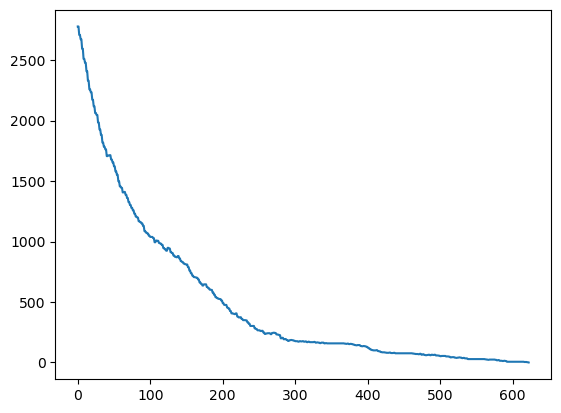

In [298]:
plt.plot(history)

In [183]:
s = random_init(1000, 32)
%time result, history = optimize(s, max_iters=1000, verbose=True, return_history=True)

Initial solution has 2940 violations
1) 2940 -> 2866
2) 2866 -> 2768
3) 2768 -> 2734
4) 2734 -> 2652
5) 2652 -> 2556
6) 2556 -> 2492
7) 2492 -> 2460
8) 2460 -> 2378
9) 2378 -> 2338
10) 2338 -> 2280
11) 2280 -> 2252
12) 2252 -> 2188
13) 2188 -> 2100
14) 2100 -> 2038
15) 2038 -> 2018
16) 2018 -> 1974
17) 1974 -> 1918
18) 1918 -> 1876
19) 1876 -> 1830
20) 1830 -> 1792
21) 1792 -> 1766
22) 1766 -> 1742
23) 1742 -> 1722
24) 1722 -> 1704
25) 1704 -> 1644
26) 1644 -> 1632
27) 1632 -> 1602
28) 1602 -> 1568
29) 1568 -> 1540
30) 1540 -> 1526
31) 1526 -> 1474
32) 1474 -> 1444
33) 1444 -> 1410
34) 1410 -> 1390
35) 1390 -> 1382
36) 1382 -> 1398
37) 1398 -> 1374
38) 1374 -> 1354
39) 1354 -> 1330
40) 1330 -> 1306
41) 1306 -> 1298
42) 1298 -> 1266
43) 1266 -> 1270
44) 1270 -> 1236
45) 1236 -> 1228
46) 1228 -> 1200
47) 1200 -> 1180
48) 1180 -> 1178
49) 1178 -> 1146
50) 1146 -> 1128
51) 1128 -> 1118
52) 1118 -> 1102
53) 1102 -> 1110
54) 1110 -> 1108
55) 1108 -> 1074
56) 1074 -> 1064
57) 1064 -> 1044
58)

KeyboardInterrupt: 

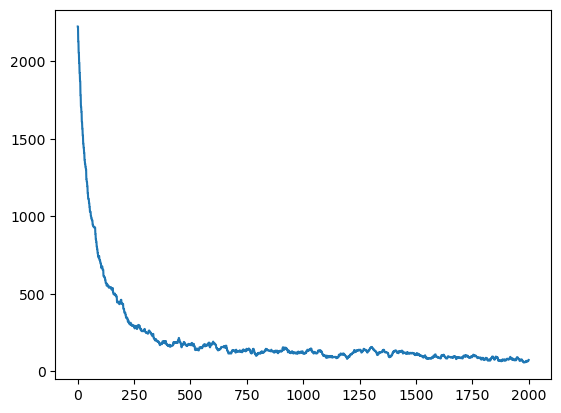

In [112]:
plt.plot(history)

In [114]:
s = random_init(1000, 24)
%time result, history = optimize(s, max_iters=1000, verbose=True, return_history=True)

Initial solution has 1476 violations
1) 1476 -> 1424
2) 1424 -> 1362
3) 1362 -> 1302
4) 1302 -> 1228
5) 1228 -> 1168
6) 1168 -> 1116
7) 1116 -> 1046
8) 1046 -> 1004
9) 1004 -> 974
10) 974 -> 966
11) 966 -> 924
12) 924 -> 880
13) 880 -> 844
14) 844 -> 832
15) 832 -> 802
16) 802 -> 752
17) 752 -> 730
18) 730 -> 696
19) 696 -> 688
20) 688 -> 674
21) 674 -> 650
22) 650 -> 646
23) 646 -> 626
24) 626 -> 614
25) 614 -> 594
26) 594 -> 606
27) 606 -> 584
28) 584 -> 558
29) 558 -> 532
30) 532 -> 518
31) 518 -> 492
32) 492 -> 466
33) 466 -> 448
34) 448 -> 440
35) 440 -> 428
36) 428 -> 412
37) 412 -> 410
38) 410 -> 388
39) 388 -> 368
40) 368 -> 336
41) 336 -> 322
42) 322 -> 300
43) 300 -> 304
44) 304 -> 306
45) 306 -> 314
46) 314 -> 284
47) 284 -> 260
48) 260 -> 244
49) 244 -> 244
50) 244 -> 242
51) 242 -> 234
52) 234 -> 222
53) 222 -> 224
54) 224 -> 222
55) 222 -> 210
56) 210 -> 192
57) 192 -> 186
58) 186 -> 182
59) 182 -> 172
60) 172 -> 166
61) 166 -> 154
62) 154 -> 148
63) 148 -> 138
64) 138 ->

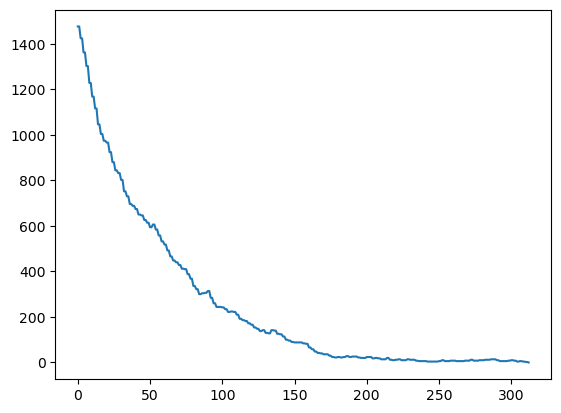

In [115]:
plt.plot(history)

In [116]:
s

{0: {0: array([747, 128, 693, 676, 797, 376, 223, 424,  21, 181, 174, 938, 666,
         177, 205, 451, 257, 885, 475, 767, 936, 409, 875, 598]),
  1: array([932, 874, 979, 562, 307, 970, 333,  19, 301, 436, 106, 335, 102,
         674, 446, 356, 295, 945, 766, 607, 139, 859,  50, 486]),
  2: array([438, 160, 600,  55,   2, 841, 881, 831, 799, 122, 590, 312, 266,
         821, 209, 974, 933, 478, 929, 552, 720, 347, 372, 368]),
  3: array([650, 242, 761, 653,  14, 479, 510, 101, 405, 985, 439, 734, 311,
          79, 951, 865, 796, 245, 893, 587, 645, 567, 563, 805]),
  4: array([890, 887, 686, 732, 329, 564, 741,  18, 456, 199, 735, 217, 958,
         271, 442,  88, 412, 809, 506, 386, 449, 901, 144,  15]),
  5: array([490, 884, 944,  31, 359, 776, 119, 176, 662, 864, 906, 615, 553,
         304, 400, 632, 129, 429, 942, 670, 649,  39, 561,  12]),
  6: array([555, 364,   9,   8, 267, 343, 581,  28, 379, 705, 243, 905, 773,
         852, 774, 448, 820, 458, 533, 955, 415, 560, 822, 403